# Django私房手册

吐槽一下，虽然django看起来很简单，常用的功能一两行代码就可以搞定，但是如果要扩展却不太容易，需要深入了解其内部流程，否则要么无从下手，要么出错以后不知如何解决，而它的内部流程有些又挺复杂的，所以个人觉得，虽然说"write less, do more"，但是"write less"了，"think"一点没"less"。

官网的3.0资料结构比2.2版本清楚很多，如下：
- [官方中文](https://docs.djangoproject.com/zh-hans/3.0/)

## 安装配置和部署

- [app如何重命名](https://stackoverflow.com/questions/8408046/how-to-change-the-name-of-a-django-app)
- [Django的时区设置问题](https://www.cnblogs.com/sunxiuwen/p/10082027.html)
- [django国际化多语言](https://blog.csdn.net/u011519550/article/details/105037945/)

### 通用步骤

1. 创建项目: `django-admin startproject MyProject`（必须）
2. 创建app: `python manage.py startapp myapp`（必须）
3. 修改settings.py，注册app（必须）
4. 设置语言和时区，settings.py中修改`LANGUAGE_CODE = 'zh-Hans'`，以及`TIME_ZONE = 'Asia/Shanghai'`
5. 在app目录下新建static文件夹存放静态文件（必须），注意，模板里面必须通过`/static/css/base.css`这样的绝对路径或者`{% load static %}`以后使用`static`标签引用静态文件。或者通过`STATIC_URL`和`STATICFILES_DIRS`配置静态文件的目录（可选）。
6. 配置模板路径，默认使用根目录下的templates文件夹（可选）
7. 配置路由，编写模型，编写视图，编写模板（顺序不固定）

### 通过nginx+uwsgi部署Django项目

首先安装uwsgi，在线安装命令为`pip install uwsgi`，本地安装在pypi搜索，下载解压缩以后，使用命令`python setup.py install`进行安装，或者直接对压缩包使用pip命令`pip install uwsgi-2.0.18.tar.gz`也可以。

安装完后运行uwsgi，看能不能找到命令（是否将uwsgi加入到环境变量），找不到的话创建软链接，比如： 
`ln -s /usr/local/python3/bin/uwsgi /usr/bin/uwsgi3` 
此次项目使用centos7.0以及anaconda软件包，默认安装的地址为`/home/noc/anaconda3/bin/uwsgi`，已经添加到环境变量里了。有可能会报错，提示有些文件找不到，解决方法如下：
```
uwsgi: error while loading shared libraries: libssl.so.1.1: cannot open shared object file: No such file or directory
sudo ln -s ~/anaconda3/lib/libssl.so.1.1 /lib64/libssl.so.1.1

uwsgi: error while loading shared libraries: libcrypto.so.1.1:
sudo ln -s ~/anaconda3/lib/libcrypto.so.1.1 /lib64/libcrypto.so.1.1

uwsgi: error while loading shared libraries: libicui18n.so.58
sudo ln -s ~/anaconda3/lib/libicui18n.so.58 /lib64/libicui18n.so.58
sudo ln -s ~/anaconda3/lib/libicuuc.so.58 /lib64/libicuuc.so.58
sudo ln -s ~/anaconda3/lib/libicudata.so.58 /lib64/libicudata.so.58
```
然后在django的项目下，就是有manage.py文件的哪个目录，新建一个xml文件，内容如下：
```xml
<uwsgi>
 <socket>127.0.0.1:8997</socket><!-- 内部端口，自定义 -->
 <chdir>/home/noc/bjw/directionflow</chdir><!-- 项目路径，manage.py文件所在目录 -->
 <module>directionflow.wsgi</module><!-- 加载指定的python WSGI模块，diango会自动生成一个wsgi.py文件 -->
 <processes>4</processes> <!-- 进程数 --> 
 <daemonize>uwsgi.log</daemonize><!-- 生成日志文件 -->
 <py-autoreload>1</py-autoreload><!--修改python文件以后自动重启-->
</uwsgi>
```
文件名应该随意，这里假设是project.xml。这里配置的是uwsgi服务的配置选项，uwsgi可以用命令行参数、xml文件、ini文件、yaml文件等多重方式进行配置，这里采用xml文件进行配置。

接下来修改nginx.conf文件，此次项目，配置文件在`/usr/local/nginx/conf/nginx.conf`目录下，在最后加入以下内容：
```json
server {
 listen 8996; #暴露给外部访问的端口
 server_name localhost;
     charset utf-8;
 location / {
     include uwsgi_params;
     uwsgi_pass 127.0.0.1:8997; #外部访问8996就转发到内部8997
 }
}
```
有几点要注意：
1. 要注意上面的内容要在conf配置文件最外面也就是默认的大括号内，保存以后进入/usr/local/nginx/sbin/目录执行`./nginx -t`命令看一下配置文件是否正确，如果nginx在环境变量PATH里，可以直接`nginx -t`。如果正确的话重启nginx服务器。如果使用lnmp安装的话，直接执行`lnmp restart`重启整个服务。
2. `uwsgi`配置文件中`module`配置的`directionflow.wsgi`表示在`chdir`配置的项目路径下，有一个`directionflow`文件夹，里面包含一个`wsgi.py`的文件。
3. `daemonize`表示后台启动，并且所有信息写入`uwsgi.log`文件。
4. `uwsgi`的配置文件配置的协议和`nginx`的要一致，这里`nginx`配置的是`uwsgi_pass`，`uwsgi`就要配置成`socket`。如果`nginx`为`proxy_pass http://127.0.0.1:5000/`,那么`nginx`就要为`<http>127.0.0.1:5000</http>`。
5. `uwsgi`还有几个配置可能有用，
 - `logdate`：log文件记录时间。
 - `buffer-size`：设置请求的最大字节数。
 
具体可以参考[这篇文章](https://blog.csdn.net/t8116189520/article/details/88388801)以及`uwsgi`[官方文档](https://uwsgi-docs.readthedocs.io/en/latest/Options.html)。  
最后进入django的项目目录，就是之前配置了uwsgi的xml配置文件的目录，执行以下命令启动uwsgi服务：
uwsgi -x project.xml
如果前面创建了软链接，则是：
uwsgi3 -x project.xml
如果都没有出错的话，现在就可以正常访问了。

要注意的是，如果配置文件中没有配置`py-autoreload`选项，加入修改了python文件是不会生效的，需要使用`killall uwsgi`命令先杀死所有的uwsgi进程，然后再使用`uwsgi -x project.xml`重新启动uwsgi服务才行。

主要参考[文章](https://www.cnblogs.com/levelksk/p/7921066.html)  
关于uWSGI，nginx和django之间的关系，可以看这篇文章[uWSGI+django+nginx的工作原理流程与部署历程](https://blog.csdn.net/c465869935/article/details/53242126)  
nginx的配置的说明，看这篇文章[Nginx 安装与部署配置以及Nginx和uWSGI开机自启](https://www.cnblogs.com/wcwnina/p/8728430.html)。

### uwsgi+django部署项目

`nginx`主要是可以用来做反向代理和虚拟主机，如果项目没有那么高的要求，可以直接适用`uwsgi`+`django`部署项目，参考以下两篇文章：
- [使用uwsgi部署Django应用](https://www.cnblogs.com/keithtt/p/10182869.html)
- [How to use Django with uWSGI](https://docs.djangoproject.com/en/dev/howto/deployment/wsgi/uwsgi/#how-to-use-django-with-uwsgi)

### 将uwsgi设置为开机启动

配置了`uwsgi`以后，`uwsgi`并不会开机启动，每次如果开机，要重新执行`uwsgi -x project.xml`命令。centos可以将可执行程序包装成服务，使用`systemctl`进行管理。基本流程如下：

进入服务配置文件目录->编写服务配置文件->使用`systemctl`管理服务。
1. 进入服务配置文件目录：
在centos 6之前的版本，一般都是在`/etc/rc.d`文件夹里面进行配置。但是这种配置很麻烦，所以6以后，建议使用服务的方式进行配置。一般系统的服务文件放在`/etc/systemd/system/`里面，个人或者三方软件的服务文件放在`/usr/lib/systemd/system`里面（使用`systemctl enable`命令时，其实是创建一个软链接指向`/etc/systemd/system/`目录，系统只会读取这个目录的内容）。要做的就是在这个文件夹里面编写一个`service`后缀的配置文件。
2. 编写服务配置文件：
`uwsgi`的配置文件内容如下，文件名可以自己定义，以`service`结尾。
    ```ini
    [Unit]
    Description=HTTP Interface Server
    After=syslog.target

    [Service]
    KillSignal=SIGQUIT
    ExecStart=/usr/bin/uwsgi --ini /path/uwsgi.ini
    Restart=always
    Type=notify
    NotifyAccess=all
    StandardError=syslog

    [Install]
    WantedBy=multi-user.target
    ```
注意，如果`uwsgi`配置文件中配置了`daemonize=/path/uwsgi.log`(uwsgi服务以守护进程运行)，会导致`sytemctl`启动时多次重启而导致启动失败需改为 `logto=/path/uwsgi.log`。  
具体的`service`配置的写法可以参考这篇文章：
[《Centos7之Systemd(Service文件)详解》](https://blog.csdn.net/Mr_Yang__/article/details/84133783)
3. 使用`systemctl`管理服务：
常用的`systemctl`的命令如下：
    - 在开机时启用一个服务：systemctl enable app-run.service  
    - 在开机时禁用一个服务：systemctl disable app-run.service
    - 启动一个服务：systemctl start app-run.service  
    - 关闭一个服务：systemctl stop app-run.service  
    - 重启一个服务：systemctl restart app-run.service  
    - 显示一个服务的状态：systemctl status app-run.service    
    - 查看服务是否开机启动：systemctl is-enabled app-run.service  
    - 查看已启动的服务列表：systemctl list-unit-files|grep enabled  
    
参考文档：[《linux /etc/rc.d/目录的详解》](https://blog.csdn.net/kunkliu/article/details/80834961)

### Django时区配置和时间相关字段的存取

在`Django`的配置文件`settings.py`中，有两个配置参数是跟时间与时区有关的，分别是`TIME_ZONE`和`USE_TZ`：
>以下为网路查到的资料，新版本不一定正确，需要测试： 
>- 如果`USE_TZ`设置为`True`时，Django会使用系统默认设置的时区，即`America/Chicago`，此时的`TIME_ZONE`不管有没有设置都不起作用。
>- 如果`USE_TZ`设置为`False`，而`TIME_ZONE`设置为`None`，则Django还是会使用默认的`America/Chicago`时间。若`TIME_ZONE`设置为其它时区的话，则还要分情况，如果是Windows系统，则`TIME_ZONE`设置是没用的，Django会使用本机的时间。如果为其他系统，则使用该时区的时间，比如设置`USE_TZ = False`, `TIME_ZONE = 'Asia/Shanghai'`, 则使用上海的UTC时间。

时间设置的时候，常会遇到以下的错误：
```python
RuntimeWarning: DateTimeField Customer.updated received a naive datetime (2016-06-19 07:18:21.118000) while time zone support is active
```
错误里说到`datetime`字段得到一个`naive datetime`，而不是支持`time zone`的`active datetime`，此时是由于`USE_TZ`设置为True，Django会自动根据所设的时区对时间进行转换。如上所说，程序中和数据保存的时间都转UTC时间，只有模版渲染时会把时间转为`TIME_ZONE`所设置的时区的时间。
在本地化的项目中，特别是前后端分离的项目，没有用到模板渲染，反而会比较麻烦，比如你写入一个字段的值的时候，如果未提供时区信息，`django`会认为是一个`native datetime`，存入数据库的时候，会直接根据`TIME_ZONE`的设置，将时间转换为`UTC`时间进行保存，而如果直接读取数据库的值，`django`并不会进行转换，导致读取的时间不手动转换的话都是`UTC`时间。

`django`关于时间相关的类是`django.utils.timezone`。`timezone.now()`返回当前时间，如果`USE_TZ`为`False`，返回一个`native time`，如果为`True`，返回一个`aware time`。但是注意，它总是返回一个`UTC`时间，需要使用`timezone.localtime()`转换成本地时间，`localtime`接受一个`aware time`时间作为参数，转换到`TIME_ZONE`设置的时区的本地时间。

### windows下django部署

#### Apache

使用apache部署，主要参考这篇文章：
- [Some pointers on installing mod_wsgi on Windows](https://l4sh.com/tech/2018/10/08/some-pointers-on-installing-mod_wsgi-on-windows.html)

但是安装mod_wsgi错误，解决方法如下：
1. 首先到`https://www.lfd.uci.edu/~gohlke/pythonlibs/#mod_wsgi`下载和python以及操作系统,apache服务器对应的版本。然后本地使用pip install进行安装，安装之前首先要升级setuptools。
2. 在线安装`pip install mod_wsgi`，这种方法需要在本地先安装正确版本的window c++编译器，可以按照文章的步骤进行安装。安装之前要先配置一下Apache的环境变量：`set MOD_WSGI_APACHE_ROOTDIR=C:/apache`

我是使用第一种方法安装成功，但是始终无法正常运行网站，最终是改用IIS部署成功。

#### IIS

- [win10服务器在iis上部署django项目](https://www.cnblogs.com/guangang/articles/9268644.html)
- [IIS8部署Django项目](https://blog.csdn.net/elonpage/article/details/52645562)

参考上面两篇文章使用IIS安装部署成功，但是有几个地方要注意：
1. IIS没法直接解析python网站，需要一个翻译，即先要安装FastCGI模块，安装以后点网站，在右侧的面版里面选择处理程序映射->添加模块映射。模块选择FastCgiModule，可执行文件填写`C:\Anaconda3\python.exe|D:\project\wfastcgi.py`，注意，wfastcgi.py文件的路径直接引用python\Lib\site-packages目录下的文件也可以，但是就不能在服务器上配置多个django网站，因为等下还要配置这一条映射规则的环境变量，将这一条规则对应到django网站，一个wfastcgi.py文件，只能够对应一个网站。

2. 添加了映射规则以后，要配置这条映射规则的环境变量，也就是将这条规则对应到具体的django网站，这里要注意的是，此时不是在网站里面设置，而是在服务器的面板里面找到FastCGI设置，点进去就可以看到刚才配置的映射，再点击具体的映射，就可以配置这一条映射的环境变量，也就是配置这条映射对应的django网站，具体配置如下：

```
get_wsgi_application()方法的位置，C:\Anaconda3\Lib\site-packages\django\core\wsgi.py
    Name: WSGI_HANDLER
    Value: django.core.wsgi.get_wsgi_application()

Django项目目录
    Name: PYTHONPATH
    Value: D:\project\

项目settings.py文件的位置
    Name: DJANGO_SETTINGS_MODULE
    Value: project.settings
```

3. 最后的静态文件无法正常显示。最终解决方案如下：
    1. 首先在settings.py里面添加`STATIC_ROOT = os.path.join(BASE_DIR, 'static')`，生产环境下必须配置这个选项。
    2. 然后命令行运行`python manage.py collectstatic`
    3. 此时会在项目根目录建立一个`static`文件夹，包含所有静态文件，包括django自带的`admin`应用。
    4. 在这个`static`文件夹的根目录下，添加一个web.config文件，内容如下：
    ```xml
    <?xml version="1.0" encoding="utf-8"?>

    <configuration> 
      <system.webServer> 
        <!-- this configuration overrides the FastCGI handler to let IIS serve the static files -->  
        <handlers> 
          <clear/>  
          <add name="StaticFile" path="*" verb="*" modules="StaticFileModule" resourceType="File" requireAccess="Read"/> 
        </handlers> 
      </system.webServer> 
    </configuration>
    ```
5. 打开IIS管理器，添加一个虚拟目录，名称是`static`，物理路径指向包含web.config的这个文件夹。
6. 网上的教程一般到这里就完了，但是实际发现仍然不能访问，提示500错误，主要是因为win10的IIS的web.config的安全策略导致，不允许更改配置，需要在管理员权限运行的cmd中运行以下命令解锁：
```
%windir%\system32\inetsrv\appcmd unlock config -section:system.webServer/handlers 
%windir%\system32\inetsrv\appcmd unlock config -section:system.webServer/modules
```
7. 至此网站应该就可以正常运行，不过如果网站使用了ajax，还要注意的就是cors跨域问题，可以通过安装插件解决，具体见网文收集。
8. 一般情况下，windows防火墙只对IIS开放了一个端口，如果配置了多个网站，多的网站外网无法访问，还需要配置windows防火墙，具体方法是控制面板->windows防火墙->高级设置->入站规则->右侧面板找到IIS入站->协议和端口，在本地端口里面配置网站绑定的端口。
9. IIS静态文件还有一个坑，就是`<img src="/img/title.png"/>`这样的图片路径，不能使用自闭合，否则浏览器页面会渲染成`<img src="/img/title.png/" ></img>`，会在图片路径最后自动加一个斜杠，导致图片无法显示。解决方法很简单，就是使用完整的写法：`<img src="/img/title.png"></img>`

### 管理和部署静态文件

- [管理静态文件](https://docs.djangoproject.com/zh-hans/3.1/howto/static-files/)
- [部署静态文件](https://docs.djangoproject.com/zh-hans/3.1/howto/static-files/deployment/)

`STATIC_URL`设置url访问静态文件的根目录，比如设置为`myapp_static`，则访问静态文件的时候url必须为 `http://127.0.0.1:8000/myapp_static/`， 注意，这个参数只是指定url静态文件根目录，和实际的文件夹名称无关。

此时如果设置了`STATICFILES_DIRS`，首先到`STATICFILES_DIRS`里面寻找静态文件,其次再到各个app的static文件夹里面找(注意, django查找静态文件是惰性查找,查找到第一个,就停止查找了)，如果没有设置这个参数，则直接到app下面的static文件夹查找，文件夹不能改名。

另外还有一个`STATIC_ROOT`的配置项，当我们正式部署上线的时候，必须要指明静态文件的目录，注意，正式上线的话这个选项是必须要配置的，我们要先配置这个选项，然后运行`python manage.py collectstatic`，将在开发模式中定义的静态目录，统一拿到`STATIC_ROOT`目录下，对外提供“/static”（`STATIC_URL`）为访问URL，它主要做了2件事：
1. 首先从Django的扩展包中，将admin管理后台的js和css等静态文件拷贝到配置文件中的STATIC_ROOT目录下。
2. 然后将STATICFILES_DIRS 列表中所有目录下的内容也拷贝到STATIC_ROOT目录下
`python manage.py collectstatic`在执行时，django默认会去查看定义在`STATICFILES_DIRS`里的目录，以及在`INSTALLED_APPS`里定义了的app的`static`目录。如果这些目录下有文件，则把文件全部收集起来，拷贝到`STATIC_ROOT`目录下。最后还要配置一下静态文件的url映射，如下：

```python
from django.conf.urls import url
from django.views import static
from django.conf import settings

# 设置项目上线的静态资源路径
urlpatterns = [
    # ... the rest of your URLconf goes here ...
] + static(settings.STATIC_URL, document_root=settings.STATIC_ROOT)
```

当创建一个项目的时候，`STATIC_URL`是自动生成的，`STATICFILES_DIRS`和`STATIC_ROOT`需要手动的配置。`STATICFILES_DIRS`是开发阶段使用，django的框架会从这个文件夹查找静态文件。而`STATIC_ROOT`用于生产环境，这两者指定的文件夹不能一样。

**<font color="red">这里有个疑问，自己在进行IIS配置的时候，没有配置url的静态文件路由映射，但是貌似也可以读取静态文件。不知道是不是因为在IIS中配置了web.config文件。如果配置了url路由映射，是否nginx或者iis就不需要再配置静态文件的路径？</font>**

在模板中，如果要读取静态文件，需要先开启`static`标签，即先在使用`static`标签之前输入：
```html
{% load static %}
```
然后，当读取静态文件的时候，就可以使用`static`标签了，比如：
```html
<script src="{% static 'js/base.js' %}"></script>
```
如果觉得要先`load` `static`标签太麻烦，可以在settings.py里面进行配置，如下：
```python
TEMPLATES = [
    {
        'BACKEND': 'django.template.backends.django.DjangoTemplates',
        'DIRS': [os.path.join(BASE_DIR, 'templates')]
        ,
        'APP_DIRS': True,
        'OPTIONS': {
            'context_processors': [
                'django.template.context_processors.debug',
                'django.template.context_processors.request',
                'django.contrib.auth.context_processors.auth',
                'django.contrib.messages.context_processors.messages',
            ],
            #添加在这个位置
            'builtins' : [
                'django.templatetags.static'
            ],
        },
    },
]
```
这样可以直接使用`static`标签，不需要事先`load`了。

其实在模板中读取静态文件，`static`标签也不是必须的，只要设置了`STATIC_URL`，就可以直接通过url读取。还是上面的例子，`STATIC_URL`被设置为`myapp_static`，那么就可以直接使用这个url读取静态文件，如下：
```html
<script src="/myapp_static/js/base.js"></script>
```
或者使用绝对地址：
```html
<script src="http://localhost:8000/myapp_static/js/base.js"></script>
```

### 调试神器debug_toolbar

- [Django Debug Toolbar的安装及使用](https://blog.csdn.net/weixin_42042680/article/details/85696629)

## URL路由配置

- [Django之url使用小技巧、项目类视图](https://blog.csdn.net/allensakaru/article/details/84205415)
- [Django应用命名空间与实例命名空间](https://blog.csdn.net/weixin_30613433/article/details/97339917)
- [路由配置技巧](https://www.jianshu.com/p/b0267cd7e2fb)
- [URL重定向的HttpResponseDirect, redirect和reverse的用法详解](https://blog.csdn.net/weixin_42134789/article/details/81505963)

### `url`路由配置和`href`属性设置路径的区别

`url`路由配置和`a`标签的`href`设置路径是完全不同的，`url`路由配置没有相对路径的概念，默认会在设置的`url`前面自动加斜杠'/'作为根目录，比如：
```python
path('login/', views.vlogin, name='login')
```
代表的路径是`http://127.0.0.1/login/`。

而`href`属性有相对路径和绝对路径概念，绝对路径不用多说，注意相对路径，如果不加`/`，则说明是在当前路径后面添加，而加了`/`，则说明是在根目录后面添加，比如：
```html
<a href='register/'>登录</a>
```
如果当前页面对应的路径为`http://127.0.0.1/login`，则`href`表示的路径为`http://127.0.0.1/login/register/`。
```html
<a href='/register/'>登录</a>
```
表示的路径为`http://127.0.0.1/register/`。

<font color="red">**小贴士：`redirect`函数的参数`url`和`href`用法一致。**</font>

### `url`路由配置后面要不要加`/`

路由配置最后是一定要加`/`或者使用`.html`之类的结尾，测试发现，如果路由配置不加`/`，比如：
```python
path('login', views.vlogin, name='login')
```
而浏览器访问`http://127.0.0.1/login`的时候，会自动在后面加上`/`，导致无法匹配的结果。

<font color="red">**注意：浏览器会自动在最后添加`/`，所以，设置`href`属性的时候可以不加`/`。**</font>

### 通过路由向视图传递格外的参数

除了通过配置url可以向视图函数传参以外，还可以通过`path`函数的`kwargs`关键字参数向视图传递格外的参数，如：
```python
path('info/', views.InfoView.as_view(), name="info", kwargs={"name": "telecomshy"})
```

### 路由的应用命名空间和实例命名空间

一般对路由我们可以通过向`path`函数传递`name`关键字参数对其进行命名，比如说有如下的路由：
```python
path('index/', views.index, name='index')
```
那么，我们在视图中，就可以通过这个`name`反向解析路由，而不用把路由地址硬编码到程序中，比如在某个视图函数中，我们要跳转到`index`页面，不用反向解析的话，我们会这样写：
```python
redirect('/index/')
```
但是，如果哪天我们把首页的路由改成:
```python
path('main/', views.index)
```
那么，我们的视图函数也要进行相应的修改，需要改成：
```python
redirect('/main/')
```
如果使用反向解析，就简单多了，跳转的代码可以这样写：
```python
redirect(reverse('index'))
```
只要`name`不变，url不管变成什么样，django都会渲染成正确的地址。

应用命名和实例命名都是针对两级路由来说的，二级路由不再详细讲解，简单说就是在`app`文件夹下面再定义一个`urls.py`文件，根目录下的`urls.py`文件可以通过`include`方法导入`app`文件夹下的`urls.py`中定义的路由，并且最终的路由是两级路由的拼接。

先看应用命名空间，设想一下这样一个场景：有两个不同的`app`，都定义了一个命名路由为`index`，那我们在反向解析的时候怎么办？显然光靠`reverse('index')`不行，此时可以在二级路由`urls.py`文件中加一行代码`app_name='app01'`，这样反向解析的时候就可以指定解析那个`app`的命名路由，比如`reverse('app01:index')`，**<font color='red'>注意一旦设置了`app_name`，就只能使用`reverse('app01:index')`这样的形式反向解析，直接`reverse('index')`会报错。</font>**

再来看实例命名空间，设想一下另一个场景，定义了两条不同的一级路由到同一个app的`urls.py`文件，比如：
```python
path('index/', include('index.urls'))
path('main/', include('index.urls'))
```
为什么这么定义，主要是为了代码复用，假设我们访问`http://localhost/index/page/`和访问`http://localhost/main/page/`，`page`在二级路由里面定义)，我们希望这两个地址显示的页面有所不同，正常情况下，如果想要显示不同的页面，需要在二级路由里面定义两个不同的`url`地址，对应两个不同的视图函数，比如在二级路由里面再定义一个`page1`和`page2`，然后分别对应不同的视图函数，但是这两个页面大部分内容都是相同的，我们想要复用代码。那么可以定义一个命名空间，比如：
```python
path('index/', include('index.urls', namespace='page1'))
path('main/', include('index.urls', namespace='page2'))
```
现在，我们只需要在二级路由里面定义一个`page`视图函数，当我们访问`http://localhost/index/page/`和访问`http://localhost/main/page/`时，都会访问这个`page`视图函数，在函数内部，我们可以通过`request.resolver_match.namespace`来区分用户是通过哪个地址访问的，比如访问的是`http://localhost/index/page/`，那么`request.resolver_match.namespace`为`page1`。其实也可以用过`request.path`来判断，此时`request.path`为`/index/page`，但是和命名路由同样的道理，最好不要使用硬编码。

命名空间会给反向解析带来一个问题，假设上面例子的二级路由是这样的：
```python
app_name = 'app01'

path('page', views.index, name='index')
```
则反向解析这条路由的时候这样写`reverse('app01:index')`(**<font color='red'>注意，使用了命名空间的二级路由文件，一定要定义app_name，否则会报错</font>**)，但是此时是应该解析成`http://localhost/index/page/`，还是解析成`http://localhost/main/page/`呢？因此，此时需要通过`reverse`函数的`current_app`参数进行指定，比如`reverse('app01:index', current_app='page1')`，则会解析成`http://localhost/index/page/`,`reverse('app01:index', current_app='page2')`，则会解析成`http://localhost/main/page/`。

## 模板

### 如何手动构筑模板

`render`函数其实就是利用了`render_to_string`，`context`等函数然后返回一个`HttpResponse`对象：
```python
html = render_to_string('path/to/your/segment.html', {'objects': objects_list})
return HttpResponse(html)
```

### 模板中的未定义变量

注意，在默认情况下，对于模板中的未定义变量，django不会抛出错误而是将其设置为空字符串。
- [使用`string_if_valid`设置变量默认值？](http://www.cocoachina.com/articles/95197)

## 探究视图

- [django中级 --- RequestContext](https://www.jianshu.com/p/8dcd635d3af6)
- [Django HttpResponse对象](https://www.cnblogs.com/lavender1221/p/12450370.html)
- [How to Work With AJAX Request With Django](https://simpleisbetterthancomplex.com/tutorial/2016/08/29/how-to-work-with-ajax-request-with-django.html)
- [ajax请求为什么收不到302状态码](https://blog.csdn.net/weixin_34194551/article/details/85589273?depth_1-utm_source=distribute.pc_relevant.none-task&utm_source=distribute.pc_relevant.none-task)
- [ajax请求如何异步返回结果](https://stackoverflow.com/questions/50961625/django-render-template-on-ajax-success?r=SearchResults)
- [根据用户所属组登录不同的页面](https://stackoverflow.com/questions/16824004/django-conditional-login-redirect)
- [Django通过next参数实现登录后跳转回到前一页的3种方法](https://blog.csdn.net/bbwangj/article/details/89172745)
- [Django中针对基于类的视图添加 csrf_exempt](https://blog.csdn.net/kongxx/article/details/77322657)  
- [Django之CSRF](https://cloud.tencent.com/developer/article/1333811)
- [通过django-cors-headers插件在Django2.0中完美解决跨域请求的问题](https://blog.csdn.net/larger5/article/details/81265339)
- [解决django的ajax请求CORS跨域问题](https://www.jianshu.com/p/506fc3c27fb5)
- [视图中获取模型字段的verbose_name](https://www.cnblogs.com/ccorz/p/huo-quDjango-model-zhong-zi-duan-ming-zi-duan-deve.html)

### 基于类的视图

- [官网-基于类的视图教程](https://docs.djangoproject.com/zh-hans/3.0/topics/class-based-views/intro/)
- [官网-类视图API](https://docs.djangoproject.com/zh-hans/2.2/ref/class-based-views/base/#templateview)

django基于类的视图非常灵活和强大，但是不太容易用好，因为需要对整个类视图的结构有比较清楚的了解，一些复杂的需求，还需要深入了解类视图的内部实现，不再像之前函数视图，只需要知道一点就可以进行开发，但是缺点就是会写很多重复代码。

以下所有视图的例子都在studyDjango项目中：

#### 基础视图

##### view视图

view视图最主要的作用就是提供`as_view`方法，在`as_view()`内部返回一个`view`方法，将传入`as_view`的关键字参数设置为view实例的类属性，然后调用view类的`dispatch`方法，`dispatch`根据请求类型调用内部的相应方法，比如`get`请求就调用内部的`get`方法，`post`请求就调用`post`方法，但是view视图本身未定义这些方法，需要自己定义。

有几点要注意：
1. `view`是一个类方法，首先调用了`View`的构造函数创建了一个`View`的实例，在构造函数中将所有传入`as_view`的关键字参数设置为实例属性。注意，传入`as_view`的关键字参数必须是已经定义的类属性。
2. 在`view`内部还调用了`self.setup`方法，将传入`view`的`args`和`kwargs`设置为`view`实例的`args`和`kwargs`属性。注意，不是传给`as_view`的参数，而是传给`view`方法的参数，即通过路由`path`传入的一些参数，比如：
```python
path('index/<int:age>/', views.IndexView.as_view(), {"name": "shy"})
```
这里`as_view`先返回一个`view`函数，再将`age`和`name`两个关键字参数传入`view`函数。

view视图的传参：  
继承`view`视图的类需要自定义各种请求方法，所有`path`中传入普通的视图函数的参数都会传入自定义的方法，在方法中自行决定传给模板的变量。

##### TemplateView视图

templateView主要作用就是提供一个get方法，返回一个渲染后的模板，节省掉以下的代码：
```python
def get(request, *args, **kwargs):
    return render(request, "template.html", locals())
```
源码如下：
```python
class TemplateView(TemplateResponseMixin, ContextMixin, View):
    """
    Render a template. Pass keyword arguments from the URLconf to the context.
    """
    def get(self, request, *args, **kwargs):
        context = self.get_context_data(**kwargs)
        return self.render_to_response(context)
```    
另外，`TemplateView`还通过继承`ContextMixin`混入类，提供一个`get_context_data`的方法，可以通过`extra_context`类属性定义一些额外的上下文参数,`get_context_data`将`path`中的所有关键字参数以及通过`extra_context`定义的字典合并以后返回，最终作为上下文传递给模板，但是注意，如果使用`re_path`并且定义了位置参数，是不会传递给模板的。`TemplateView`和模型没有关系，只实现了一个`get`方法，因此只能响应`get`请求。

templateview的传参：
templateview实现了get方法，所以除非覆盖它的get方法，否则传给模板的参数是由templateview的get方法决定的。所有的django类视图传给模板的内容都是一个字典，django中称之为context上下文，templateview的上下文由`ContextMixin`混入类决定。最终传入模板的`context`由`path`中定义的`kwargs`关键字参数构成的字典，视图类定义的`extra_data`字典合并构成，另外`get_context_data`方法还在`context`字典中添加了一个`view`的键，指向视图类实例本身。

##### RedirectView视图

与其叫它视图，不如说是一个接口，`RedirectView`直接继承`View`视图，实现了一个`get`方法完成重定向，其它所有类型的请求均调用内部`get`方法进行重定向。它有几个类属性:
1. permanent  
表示是临时重定向还是永久重定向，如果为`True`,返回http状态码为301，如果为`False`，返回的http状态码为`302`，默认是`False`。


2. url  
定义要重定向的url，默认为None，如果为None，则会返回410 gone状态码，表示请求的服务器资源不可用，并且没有任何已知的转发地址。chrome返回的结果如下，firefox返回的则是空白页：
```
找不到 127.0.0.1 的网页  
该文件可能已被移至别处或遭到删除。  
HTTP ERROR 410
```
path中传递的所有关键字参数可以在url中使用%的格式化方法进行填充。注意，源码中已经写死，只能使用%的格式化方法，不能使用format进行格式化。比如想要重定向到`view_demo/<str:guestname>/`，如果自身的path定义为`redirectview_demo/<str:name>/`，那么url则要定义为`http://127.0.0.1:8000/view_demo/%(name)s/`，name会被path传递的name关键字填充。


3. pattern_name  
pattern_name定义用于反向解析url的name名称，比如想要重定向到`view_demo/<str:guestname>/`的path，其name为'view_demo'，pattern_name设置为`view_demo`，自身的url传递的参数会用来反向解析`view_demo`的url，因此应该设置为`redirectview_demo/<str:guestname>/`，参数设置需要和`view_demo`一致。注意，此时url不能设置，否则以url设置为准。


4. query_string  
这个参数比较好理解，如果是否允许get请求带查询参数，如果为`True`，那么查询参数也会被转发，如果为`False`，查询参数会被忽略。

#### 通用展示视图

通用展示视图主要将视图与模型结合起来，包含`ListView`和`DetailView`两个视图类，分别将批量的模型实例和单个模型实例传递给模板。

##### DetailView

最简单的DetailView只需要定义一个`model`类属性，如下：
```python
class DetailViewDemo(DetailView):
    model = Album
```
然后定义一个url，例如`path('detailview_demo/<int:pk>/', views.DetailViewDemo.as_view())`和一个模板`mysite/templateview_demo.html`就行了，不过不能随意定义url和模板的路径和名称。我们梳理一下整个流程，中间穿插介绍重点的参数：
1. DetailView首先会根据url路由定义的pk或者slug，去获取模型实例，并将其添加到`context`上下文中，实现这部分功能的主要是`SingleObjectMixin(ContextMixin)`混合类，主要有以下几个类属性：
 - queryset = None
 - slug_field = 'slug'
 - context_object_name = None
 - slug_url_kwarg = 'slug'
 - pk_url_kwarg = 'pk'
 - query_pk_and_slug = False
 
 首先会从url中根据pk_url_kwarg提取模型实例的pk值，默认为'pk'，如果url传递了slug，并且没有传递`pk`或者`query_pk_and_slug`为`True`，则会根据`slug`的值提取模型实例，`DetailView`会在`queryset`定义的`QuerySet`结果集中，根据提取到的`pk`或者`slug`值去过滤。如果`queryset`没有定义，则默认为模型的所有实例：`Album.objects.all()`。过滤结果是只有一个值或者空值的`QuerySet`，最后通过`queryset.get`获取单个实例，如果`queryset`为空，则抛出404错误。`SingleObjectMixin`覆写了`ContextMixin`的`get_context_data`方法，给上下文添加了一个`{"object": album_instance}`的键值对，其中"object"的键由`context_object_name`定义，默认为`"object"`,注意，即使设置了`context_object_name`，`object`的键仍然是可用的，并不会被覆盖。
 
 注意`slug_field`和`slug_url_kwarg`的区别，`slug_field`定义模型字段的名称，即使用`filter`搜索的时候，`slug`字段的名称，例如`Album.objects.filter(slug_field='slug_url_kwargs')`。而`slug_url_kwarg`是在定义`url`时，对应的关键字参数的键的名称，比如：`path('detailview_demo/<slug:slug>/', views.DetailViewDemo.as_view())`,第二个`slug`就是`slug_url_kwarg`，`slug`会作为关键字参数传给视图函数。


2. 接下来是获取模板，由`SingleObjectTemplateResponseMixin(TemplateResponseMixin)`提供这部分的功能。如果定义了`template_name`的类属性，那么直接根据上下文渲染模板，如果没定义"template_name"类属性，则有两个类属性来决定模板路径：
 - template_name_field：默认为None，它会在模型实例上面查找`template_name_field`定义的属性，其值插入模板名称的列表中。比如`template_name_field`设置为`url`，则会在`Album`实例上面查找`url`属性，不过没太明白的是，平时也没有地方设置实例属性，除非重写模型的`__init__`方法，设置一个`url`的实例属性或者专门定义一个url的字段。
 - template_name_suffix：默认为`_detail`，会以`{app_name}/{model_name}_{template_name_suffix}`的结构构建模板的路径。

 `template_name_field`和`template_name_suffix`不冲突，两者都会向一个模板列表中插入值，不同的是`template_name_field`是`insert`，在开头插入，而`template_name_suffix`在尾部添加，查找模板的时候会查找整个列表，只要找到模板就会返回。

##### ListView

ListView和DetailView大体相似，增加了很多分页的内容，其它值得注意的地方有：
1. `queryset`和`get_queryset`方法共同决定返回的`QuerySet`集合，如果有比较复杂的逻辑，可以覆写`get_queryset`方法。
2. 传递给模板的实例集合的键值由`context_object_name`确定，如果`context_object_name`没有设置，默认为`object_list`，也可以是`{model_name}_{list}`，两者皆可。
3. 注意！！！ListView在`get`方法通过`get_context_data`获取上下文时，没有传递任何path传入的关键字参数，因此关键字参数在模板中是不能直接使用的。不过，所有的位置参数和关键字参数都是保存在实例的`aelf.args`和`self.kwargs`里的，因此可以覆写`get_context_data`方法手动进行设置。
4. 模板的位置由`template_name`确定，如果没有设置的话，默认路径为`{app_label}/{model_name}_{template_name_suffix}.html`。
5. 最后有个需要注意的类属性就是`allow_empty`，如果设置为`True`，则允许返回空列表，如果为`False`，则会抛出404错误。默认为`True`。

#### 通用编辑视图

以上的视图主要响应get请求，从数据库获取数据并进行展示，但是如果页面包含表单，需要增加，更新和删除，则需要使用通用编辑视图。

##### FormView

表单视图是最基础的通用编辑视图，其与模型无关。它继承了`TemplateResponseMixin`, `BaseFormView`，其中`BaseFormView`又继承`FormMixin`和`ProcessFormView`。`FormMixin`提供创建表单，传递上下文等和表单相关的功能，`ProcessFormView`提供`get`，`post`，`put`三个方法。主要有以下几个可配置的类属性：
1. `initial={}`：设置表单的初始值，也可以在表单字段里面通过关键字参数`initial`指定。
2. `form_class`：指定表单的类。
3. `success_url`：指定提交成功后跳转的页面。
4. `prefix`：指定在html页面上生成组件的前缀。例如，如果未指定`prefix`，是这样：
```html
<label for="id_name">专辑名称:</label>
<input type="text" name="name" maxlength="50" required="" id="id_name">
```
添加一个`prefix=album`，变成下面这样：
```html
<label for="id_album-name">专辑名称:</label>
<input type="text" name="album-name" maxlength="50" required="" id="id_album-name">
```

因为继承了`TemplateResponseMixin`，因此模板视图的所有属性也可以配置。

如果要扩展，在页面数据提交成功以后实现一些自己的逻辑，需要覆盖`form_valid`方法。源码里面是这样：
```python
def form_valid(self, form):
    """If the form is valid, redirect to the supplied URL."""
    return HttpResponseRedirect(self.get_success_url())
```
这个钩子函数接受一个`form`参数，在执行完`form.is_valid()`以后调用，因此`self.cleaned_data`可以在方法内部使用。

##### CreateView

`FormView`还要额外建立一个`Form`表单或者`ModelForm`模型表单，并通过`form_class`指定这个表单，使用`CreateView`，这一步都省掉了，它能自动建立一个`ModelForm`模型表单。
使用`CreateView`主要注意几点：
1. 模板和跳转的url都可以不设置，采用默认值，但是要分清楚两者的区别:
 - 模板由SingleObjectTemplateResponseMixin混合类生成，CreateView覆盖了template_name_suffix，默认的模板为"appname/modelname_form.html"
 - 如果没有提供success_url,则会以模型的get_absolute_url()方法返回值为准。
2. 可以和普通表单一样，定义form_class类属性来指定表单，但是注意，即使定义了form_class，仍然要定义model。

### 如何通过内置通用视图快速实现用户登录

- [How to extend Django AuthenticationForm](https://stackoverflow.com/questions/56183127/how-to-extend-django-authenticationform)

除非需要对通用视图进行扩展，否则都不需要编写自己的视图代码就可以实现用户的验证登录，步骤如下：
1. 从`django.contrib.auth.views`导入`LoginView`和`LogoutView`。
2. 配置好`urlconf`，通过`template_name`参数指定模板位置，注意，模板里的变量通过`extra_context`参数传递。
3. 可以在路由配置里面直接使用`logout_then_login(request, login_url=None)`函数代替`LogoutView`。
4. `LoginView`没有参数可以设置登录成功以后跳转的页面，默认通过`setting`文件的`LOGIN_REDIRECT_URL`参数指定，或者通过`extra_context`参数传递`next`变量给模板，如`extra_context={'next': '/index/'}`。
5. 注意，`LogoutView`通过`next_page`参数指定注销后跳转的页面，默认为`LOGOUT_REDIRECT_URL`的配置，而`logout_then_login`通过`login_url`参数指定注销后的跳转页面，默认为`LOGIN_URL`的配置。

官网的模板例子中，关于`next`的部分有点难以理解，如：
```html
{% if next %}
    {% if user.is_authenticated %}
    <p>Your account doesn't have access to this page. To proceed,
    please login with an account that has access.</p>
    {% else %}
    <p>Please login to see this page.</p>
    {% endif %}
{% endif %}
```
另外，在`form`里面，还有一个设置：
```html
<input type="hidden" name="next" value="{{ next }}">
```
现梳理如下：
1. 当用户访问别的页面而不是登录页面，那么有两种可能，一种是用户没有登录，一种是用户已经登录，但是没有权限。不管哪种情况，都应该跳转到登录界面，同时url会携带`?next=`的`get`参数。
2. 此时登录页面的`view`视图类获取跳转页面url的主要逻辑如下：
```python
redirect_to = self.request.POST.get(
    self.redirect_field_name,
    self.request.GET.get(self.redirect_field_name, '')
)
```
它会首先检查`post`的数据是否包含`next`参数，否则就取`GET`请求中带的`next`参数，由于此时直接由别的页面跳转而来，是`GET`请求，因此此时获取的是`url`带来的`next`参数，然后`view`视图开始渲染页面，此时会将`next`参数传递给模板，如下：
```python
context.update({
    self.redirect_field_name: self.get_redirect_url(), # 携带了next参数
    'site': current_site,
    'site_name': current_site.name,
    **(self.extra_context or {})
})
```
传递给模板的上下文中携带了`next`参数，此时模板如果设置了:
```html
<input type="hidden" name="next" value="{{ next }}">
```
那么此时这个`input`的`next`就被设置了。当用户填写完用户名，密码提交，此时这个`input`的`value`又会传递给登录页面的`view`视图，并且以它会准。而对于模板来说，当`view`视图传递过来的上下文包含`next`参数时，说明是从别的页面跳转过来的，此时需要判断，如果用户已经登录，则说明用户没有权限访问原来的页面，因此
```html
<p>Your account doesn't have access to this page. To proceed,
please login with an account that has access.</p>
```
这一段话是告之用户账户没有权限，里面的`this page`是指用户之前访问的页面。如果用户未登录，则简单提示用户进行登录。
3. 如果是直接登录，不是由其它页面跳转而来，上面的流程最后得出的跳转`url`为空，此时：
```python
def get_success_url(self):
    url = self.get_redirect_url()
    return url or resolve_url(settings.LOGIN_REDIRECT_URL)
```
如果为空的话，会取配置里的`LOGIN_REDIRECT_URL`作为跳转url。
4. 同时，页面模板里面需要设置一个不可见的`input`，将`next`的内容，即之前访问页面的url和用户面密码一起传给后台，后台的`view`视图在判断用户合法以后，则会直接重定向到`next`指定的url去。

上面的流程还漏了一步，当最后更新上下文时，会使用`extra_context`的设置进行覆盖，所以如果此时在`extra_context`中设置了`next`，则会覆盖掉上面的`next`。所以通过`extra_context`设置`next`和设置`LOGIN_REDIRECT_URL`是不同的，如果在`extra_context`里设置`next`，那么登录以后返回原始页面的机制会失效，因为`next`总是为`extra_context`设置的值。

另外还有一点要注意，`LOGIN_REDIRECT_URL`可以设置为url的`name`，也可以是普通的路径，如果带有`/`，则django会当成是普通路径，如果不带`/`，则django会作为url的`name`进行反向查找。

登录有几个参数配置需要放在一起说一说：
1. `LOGIN_REDIRECT_URL`: 当用户登录成功以后的跳转界面，这个设置只能在settings.py里设置。
2. `LOGIN_URL`：如果用户视图类继承了`AccessMixin`（系统提供的`LoginReqiredMixin`等类都继承了`AccessMixin`），那么登录视图对应的页面如果没有通过测试，比如未登录的用户或者权限不够，则会首先检查这个视图类的`login_url`的属性，如果属性没有配置，则会取`settings.py`的`LOGIN_URL`值，作为跳转页面。
3. `LOGOUT_REDIRECT_URL`：如果用户视图继承了`LogoutView`，那么当用户登出系统，由这个值来指定登出以后的跳转页面。

官方资料里面对于登录授权的页面有点难找，链接是[使用django自带的验证系统](https://docs.djangoproject.com/zh-hans/3.0/topics/auth/default/)。

### 内置视图中的`redirect_field_name`字段到底起什么作用

官方文档的说明非常简单，只有一句话：
> GET 字段包含的登录后跳转 URL 的参数名称。默认是 next。

乍一看看简单，但是却不知道到底该怎么用。折腾了一番，有一点心得，总结如下：

`redirect_field_name`用在`LoginView`视图和普通的继承了`LoginRequiredMixin`混入类的视图时，起到的作用是不一样的。
1. 当在继承`LoginRequiredMixin`的视图中定义了`redirect_field_name`，比如设置为`jump`，当一个未授权的用户访问页面，假设该页面地址为`product`，此时会重定向到指定的url，假设为`/login/`，此时会在重定向的url后面加上一个`get`请求，这个`get`请求的键就是`redirect_field_name`定义的值，假设值为`jump`，此时完整的url就是`http://127.0.0.1:8000/login?jump=/product/`。此时如果重新登录，配置正确的情况下，会根据`jump`的值又跳转到`/product/`页面。即平时常见的，登录以后回到之前浏览的页面。
2. 在登录页面中，`redirect_field_name`起到的作用不同，`LoginView`视图会捕获从页面`post`过来的请求，假设`redirect_field_name`定义为`jump`，用户登录以后就会重定向到`request.post['jump']`指定的`url`，因此页面里面需要有一个`field`的`name`是`jump`:`<input type="hidden" name="jump" value="{{ jump }}">`。
3. 最后总结一下完整的流程，以上面假设的`url`为例：
 1. 未授权用户访问`http://127.0.0.1:8000/product`，此时无法登录，则向网址`http://127.0.0.1:8000/login/?jump=/product/`发起`get`请求。
 2. `/login/`对应的模板里面有`<input type="hidden" name="jump" value="{{ jump }}">`代码，此时会被渲染成`<input type="hidden" name="jump" value="/product/">`。
 3. 点击登录按钮，此时会向`http://127.0.0.1:8000/login/`发起`post`请求，请求里面包含了`request.post['jump']=product`。由于在`LoginView`中也要设置`redirect_field_name`为`jump`，因此此时登录以后会直接跳转到`http://127.0.0.1:8000/product/`页面。

## 模型与数据库

- [官网-模型文档](https://docs.djangoproject.com/zh-hans/3.0/topics/db/models/#field-types)
- [官网-使用django的验证系统](https://docs.djangoproject.com/zh-hans/2.2/topics/auth/default/)


- [如何根据已有数据表生成model类](https://www.cnblogs.com/pythonywy/p/11379373.html)
- [Django model update的各种用法介绍](https://www.jianshu.com/p/1760dcfdb39f)

### 基本操作

#### 删除模型类的步骤

1. 删除模型类的代码。
2. 删除`migrations`文件夹下面对应的操作记录文件。
3. 删除`django_migrations`表中对应的生成记录。
4. 最后删除数据库中的数据表。

#### 动态获取模型类

有时候需要动态的获取模型类，目前发现有两种方法：
1. 使用apps的get_module方法：
    ```python
    from django.apps import apps

    apps.get_model('app_name', 'module_name')
    ```
2. 使用contenttypes框架，contenttypes框架是什么不多说，刘江博客教程有详细介绍，这里只利用它动态获取模型，代码如下：
    ```python
    from django.contrib.contenttypes.models import ContentType
    # django默认会生成一张django_content_type的表，里面保存了所有app和module的对应关系
    # 先通过app_name和module_name获取content_type的实例，其实就是django_content_type表里的一行
    model_content_type = ContentType.objects.get(app_label='app_name', model='model_name')
    model = module_content_type.model_class()
    ```

#### 修改模型字段以后makemigrations报错

修改模型字段以后，`python manage.py makemigrations`报错，提示:
```
You are trying to add a non-nullable field 'cellid' to lte without a default; we can't do that (the database needs something to populate existing rows).
```
可以先在模型上设置：
```python
class Meta:
    abstract = True
```
设置以后更新，会删除原表。然后再将`abstract=True`注释掉，再次更新即可。不过数据会被清空。

#### Django模型转为json或者字典的方法

##### 方法1：利用`JsonResponse`手工构造json对象

代码如下：
```python
from django.http import JsonResponse
from mysite.models import Product

def get_product(request):
    products = Product.objects.all()
    d = [{'name': p.name} for p in products]
    return JsonResponse(d)
```

##### 方法2：利用`Serializer`将`queryset`转换为特定对象

可以通过`django`的`serialize`函数直接将模型序列化，返回`json`对象：
```python
from django.core.serializers import serialize

json = serialize('json', Product.objects.all(), fields=["name", "type"])
```
注意，`serialize`的函数签名是`serialize(format, queryset, **kwargs)`，可以直接返回的格式，第二个参数只能是`queryset`类型，且直接返回的是json格式的字符串，另外可以通过`fields`参数指定要返回的字段。返回的结果如下：
```python
'[{"model": "mysite.product", "pk": 1, "fields": {"name": "\\u8363\\u8000", "type": 1}}...]'
```

##### 方法3：利用`model_to_dict`将模型实例转为字典

`serialize`只能转换`queryset`类型，如果是单个的模型实例，可以通过`django`的`model_to_dict`方法转换：
```python
from django.forms.models import model_to_dict

model_to_dict(Product.object.get(id=1), fileds=["name"])
```
同样可以通过`fields`参数指定要返回的字段，直接返回字典。

### 模型的增删改查

#### F函数

- [在Django中使用F函数](https://www.cnblogs.com/zknublx/p/6401253.html)

#### Q函数:模型查询的与和或

- [django中的Q()函数：应用于model数据查询的与(and)或(or)操作](https://www.lookfor404.com/django%E4%B8%AD%E7%9A%84q%E5%87%BD%E6%95%B0%EF%BC%9A%E5%BA%94%E7%94%A8%E4%BA%8Emodel%E6%95%B0%E6%8D%AE%E6%9F%A5%E8%AF%A2%E7%9A%84%E4%B8%8Eand%E6%88%96or%E6%93%8D%E4%BD%9C/)

使用Q函数要注意一点是：关键字参数一定要放在Q函数的后面，不能放在前面。

#### 建立关联表的注意事项

1. Django建立表如果没有设置`primary_key`主键，Django会自动设置一个自动增长的`id`列作为主键。如果设置了主键列，则不会添加`id`列。
2. 建立关联表，不需要指定具体的列，只需要指定表就行了，Django会根据主键列进行关联，例如有2张表，`productType`表和`product`为一对多的关系，只需要在`product`的表里面添加一列类型为`ForeignKey`即可，列名可以任意，Django会自动在后面加上`_id`，里面的内容必须属于`productType`的主键列。

#### 给关联字段起别名

上面一个问题的搜索语句：
```python
Wheel.objects.values("car__factory")
```
返回的结果是是一个字典，`<QuerySet [{'car__factory': '奔驰'}]>`，返回的字典的键中，字段名`car`会在前面，现在想要返回的结果是`<QuerySet [{'factory': '奔驰'}]>`，可以使用`annotate`别名：
```python
from django.db.models import F

Wheel.objects.annotate(factory=F("car__facotry")).values("factory")
```
另外，`.extra()`方法也可以更改别名，但是在关系型字段中无效，原因暂未知，以后知道了再补充。

#### 关联表查询注意事项

##### 主表查次表

假设如下两个模型，代码如下：
```python
class ProductType(models.Model):
    type = models.CharField(max_length=20)


class Product(models.Model):
    name = models.CharField(max_length=50)
    type = models.ForeignKey(ProductType, on_delete=models.CASCADE, related_name="ps", related_query_name="p")
```
把定义了外键的表称为主表，在这里，`Product`是主表，`type`是外键，`ProductType`是次表，如果通过主表查次表，可以通过外键加`__`两个下划线查询：
```python
Product.objects.values("type__type")
```
<font color=red size=2>***注意，实际的`Product`表中实际没有`type`这个字段，只有`type_id`，里面保存的是`ProductType`表中对应的主键`id`的值。***</font> 

搜索也是一样，如果要根据`ProductType`表的`type`字段来过滤，要这样写：
```python
Product.objects.filter(type__type="华为")
```
这里其实就是省略了`select_related`方法。可以这样记忆：`__`表示对应，主表的`type`对应的次表的`type`。

##### 次表查主表

次表查主表麻烦一点，如果查询结果是次表里的字段，查询结果只有一个，则可以通过传递参数实现，如下：
```python
ProductType.objects.filter(product__name="荣耀")
```
<font color="red" size=2>***注意：`product`是主表的名称，必须要小写。此时可以使用`related_query_name`进行引用，`Product.objects.filter(p__name="荣耀")`。***</font>

如果查询结果是主表里的字段，查询的结果有多个，通过小写的主表名称加`_set`后缀：
```python
t = ProductType.objects.get(id=1)
t.product_set.values("name")
```
<font color="red" size=2>***注意：此时也使用`related_name`引用，`t.ps.values("name")`，另外，反向查询其实也可以通过主表查次表的方法进行查询。***</font>

#### `related_name`和`related_query_name`的区别

上面的例子已经基本说明了两者之间的区别，总结如下：
1. 二者全部定义在主表，即代表"多"的字段。
2. 两者都是次表用来关联引用主表的。
3. `related_name`用作次表实例的属性，用来返回多个主表的实例。
4. `related_query_name`用作次表方法的参数，用来返回单个次表的实例。

#### 从表包含多个关联到相同主表的外键

有如下的模型：
```python
from django.db import models


class Classes(models.Model):
    #这个是班级表，是主表；
    c_name=models.CharField(max_length=20)
    class Meta:
        db_table='classes'
        
        
class Student(models.Model):
    #这个是学生表，是从表
    s_name=models.CharField(max_length=20)
    #从表关联两个主表的外键
    classes_one=models.ForeignKey(Classes,on_delete=models.CASCADE)
    classes_two=models.ForeignKey(Classes,on_delete=models.CASCADE)
    class Meta:
        db_table='student'
```
此时会报`fields.E304`错误，因为在django中，`filter`查询的格式为`表名（类名）__字段（属性）`，因此，如果你现在想根据班级名称来查询Student从表，通常情况下是这样写：
```python
Students.objects.filter(Classes__c_name="class one")
```
显然，此时会产生混淆，因为不知道这个`Classes`到底是`classes_one`，还是`classese_two`，所以此时外键需要提供`related_name`参数或者`related_query_name`，如果没有`related_query_name`，则会采用`related_name`，如下：
```python
    #related_name指定外键的关联名称，这个名称是用于将来查询数据使用的。只在根据主表的字段查从表时会用到。
    classes_one=models.ForeignKey(Classes,on_delete=models.CASCADE,related_name='cls_one')
    classes_two=models.ForeignKey(Classes,on_delete=models.CASCADE,related_name='cls_two')
```
再进行查询的时候，就可以这样写，这样就不会产生混淆：
```python
Students.objects.filter(cls_one__c_name="class one")
```

#### 关系管理器

- [关系管理器](https://docs.djangoproject.com/zh-hans/3.2/ref/models/relations/)

从次表查询主表，即一对多中，一的一方，比如` blog.entry_set`，或者多对多的两边，返回的是一个关系管理器。可以通过关系管理器管理主表的条目，比如添加到查询集、创建主表条目、删除等等。但是对于内置的groups、user和permission，彼此之间是多对多的关系，但是要格外注意，默认可能不是表名_set：
- group查user: `group.user_set`
- user查group: `user.groups`  ⭐
- user查permission, `user.user_permissions` ⭐
- permission查user: permission.user_set
- group查permission, `group.permissions` ⭐
- permission查group: permission.group_set

django这种做法很容易让人迷惑，花费大量时间在查阅官方文档上。

#### django的批量更新

- [How to 'bulk update' with Django?](https://stackoverflow.com/questions/12661253/how-to-bulk-update-with-django)
- [Efficient Bulk Updates with Django Rest Framework](https://levelup.gitconnected.com/really-fast-bulk-updates-with-django-rest-framework-43594b18bd75)

#### select_related 和 prefetch_related函数优化查询

- [select_related和prefetch_related函数优化查询](https://blog.csdn.net/secretx/article/details/43964607)
- [select_related和prefetch_related的区别](https://stackoverflow.com/questions/31237042/whats-the-difference-between-select-related-and-prefetch-related-in-django-orm)

### 模型的字段

#### 时间字段auto_now和auto_add_now

- [django：DateTimeField如何自动设置为当前时间并且能被修改](https://www.cnblogs.com/LYliangying/articles/9778660.html)

#### 设置Django模型字段默认为`Null`

Django默认不能设置字段为`null`,如果要设置，一共有3个选项进行配置，有细微的差别，如下：
- `blank=True`，允许啥都不写入，比如`"",None`并且保持它为空，主要指前端表单`/admin/etc`中是否需要验证该值，对数据库没有影响。因为模型的字段和表单的字段是不同的，模型的字段里面没有`required`参数，因此当在视图中，将模型字段自动转换成表单字段的时候，这个`blank=True`，就会被转换成表单字段里面的`required=False`。
- `null=True`表示数据库允许该字段为`Null`。
- `default=None`如果没有给出指定的值，那么该字段在数据库中表示为`Null`，它并不管数据库是否允许`Null`值。

根据文档，对于字符串类型的字段，只要设置了`null=True`，如果传入的是空值（比如`Null`或者`""`空字符串），django会统一设置为`Null`，默认是`False`。因此如果想让某字段默认为`Null`，设置`null=True`就好了。

#### 模型`Field`和表单`Field`的区别

要注意，模型的`Field`和表单的`Field`是不同的，但是个人觉得要吐槽的是，django没有严格的区分两者，可能是为了复用，但是这样导致了概念不清。在创建`Model`的字段时`Field`时，同样可以设置`validator`,`help_text`,`error_messages`等参数，但是这些参数其实在模型中并没有起到什么作用，只是如果后期使用模型表单`ModelForm`进行扩展时，这些参数可以方便的转换成表单`Field`的属性，可是表单`Field`又有一些属性是模型`Field`不允许的，比如`required`和`label`等参数，因此建议，在创建模型字段的时候，尽量只使用对`Model`模型有意义的参数，后期要转换成表单字段时，再进行添加和修改。
- [字段的参数](https://www.liujiangblog.com/course/django/97)

#### 如何获取模型字段的verbosename

#### 字段的choices参数

模型字段的`choices`参数主要是用于将模型字段和表单字段进行互相转换，比如如下的模型字段：
```python
TITLE_CHOICES = [
    ('MR', 'Mr.'),
    ('MRS', 'Mrs.'),
    ('MS', 'Ms.'),
]

class Author(models.Model):
    name = models.CharField(max_length=100)
    title = models.CharField(max_length=3, choices=TITLE_CHOICES)
    birth_date = models.DateField(blank=True, null=True)

    def __str__(self):
        return self.name
```
自动转换成表单字段时，就变成：
```python
class AuthorForm(forms.Form):
    name = forms.CharField(max_length=100)
    title = forms.CharField(
        max_length=3,
        widget=forms.Select(choices=TITLE_CHOICES),
    )
    birth_date = forms.DateField(required=False)
```
其中元组中第一个元素是保存在数据库的值，也是转换成表单字段，html渲染时`input`组件的`name`值。  
注意：模型保存的时候并不会对`choices`做任何验证操作，即使不在选项里面，也是可以保存的，并不会报错。

#### DatetimeField的格式化

默认在`setting`中，如果启用了时区，即`USE_TZ`如果设置为`True`，则`DatetimeField`字段会携带时区信息，保存在数据库中会是`2020-12-14T09:37:00.000`的样式，如果将`USE_TZ`设置为`False`，此时`USE_L10N = True`，本地化也应该设置为`False`,则不会携带时区信息，保存在数据库中是`2020-12-14 09:37:00.000`的样式。

一般情况下，原生日期对象就足够了，此时如果要获取当前的时间，可以使用`datetime.datetime.now()`方法，但是如果`USE_TZ`为True，则Django使用`time-zone-aware`日期对象。此时创建日期对象，应该也是aware的，此时要获取当前时间，应该使用django提供的`timezone.now`方法：
```python
from django.utils import timezone
now = timezone.now()
```
不论是否使用时区，保存在数据库的时间都会带小数点，如果前端显示的时候想要改变带小数点的默认格式，在视图中可以手动的通过`datetime.strftime`方法修改，在模板中可以利用过滤器进行修改，还可以在`setting`中，使用`DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'`，全局修改输出的格式。

但是，如果使用的是restframework，日期时间的字段签名为`DateTimeField(format=api_settings.DATETIME_FORMAT, input_formats=None)`，默认情况下，`format`为`iso-8601`，会对数据库的日期时间字段的原始值进行格式化，要格外注意的是，restframework并不使用django的格式化配置，因此在django中配置的`DATETIME_FORMAT`并不生效，因此默认情况下，restframework的输出，仍然是`2020-12-14T09:37:00.000`的样式，可以直接通过`format`参数指定格式，也可以在配置文件中统一配置：
```python
REST_FRAMEWORK = {
    'DATETIME_FORMAT': "%Y-%m-%d %H:%M",
}
```
注意，`format`参数还可以设置为`None`，此时日期时间编码将由渲染器确定，即在`to_representation`钩子函数中自定义输出的格式。

### 扩展用户系统步骤

- [Django使用Profile扩展User模块方式](https://94e.cn/info/455)

有几点要注意：
1. 扩展自定义的User模型，四种方法，一般采用继承`AbstractUser`的方法。在自己的`models`文件中继承`AbstractUser`类以后，在`settings`文件中增加配置`AUTH_USER_MODEL='userapp.User'`，注意打引号，不然报错。**<font color='red'>注意：1. 如果确定要扩展，那么在项目最初，第一次进行数据库迁移的时候就进行配置，哪怕不增加任何字段，只是单纯继承`AbstracUser`，后期再增加字段都可以，否则可能出现各种问题。2. 如果自定义的用户模型，注意写法直接是`userapp.user`，而不是userapp.models.user。</font>**

2. 自定义的用户模型在后台的管理系统中是看不到的，还需要配置，主要有以下几个地方：
 - 首先在后台管理系统中登记自定义模型，修改app中的admin.py文件如下：
 
```python
from django.contrib import admin

from .models import MyUser
from django.contrib.auth.admin import UserAdmin


@admin.register(MyUser)
class MyUserAdmin(UserAdmin):
    list_display = ['username', 'email', 'mobile', 'is_staff']
    fieldsets = UserAdmin.fieldsets
    # 记住fieldsets的具体格式
    fieldsets[1][1]["fields"] = fieldsets[1][1]["fields"] + ("mobile",)
```
其中list_display修改的是进入管理系统以后，选择用户管理->用户，每个用户显示的字段：
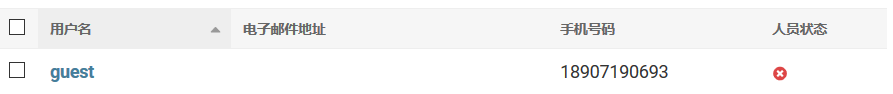

`fieldsets`修改的是点击用户名以后，用户的详细信息，其结构如下：
```python
((None, {'fields': ('username', 'password')}),
 ('个人信息', {'fields': ('first_name', 'last_name', 'email', 'mobile')}),
 ('权限', {'fields': ('is_active', 'is_staff', 'is_superuser', 'groups', 'user_permissions')}),
 ('重要日期', {'fields': ('last_login', 'date_joined')}))
 ```
 
`fieldsets[1][1]["fields"] = fieldsets[1][1]["fields"] + ("mobile",)`就是给个人信息栏中增加手机的字段。
另外还有个`add_fieldsets`用来设定创建新用户时必须需要填写的字段，默认情况下为`username`，`password1`，`password2`。一般情况下不用修改，但是如果你添加了一些`unique`的字段，比如电话号码，在创建新用户时就必须提供该项，否则会报错，此时就必须要把电话号码添加到`add_fieldsets`中。

 - 最后还需要修改app在管理系统中显示的名字，默认是`app`的名称，在app的`__init__`文件中加入如下代码：

```python
from django.apps import AppConfig
import os

# 指定自己的app的配置文件
default_app_config = "mysite.MysiteConfig"


class MysiteConfig(AppConfig):
    # name是必须指定的，没法继承，AppConfig里没有name属性，不指定会报错
    name = os.path.split(os.path.dirname(__file__))[-1]
    verbose_name = "用户管理"
```
其中`name = os.path.split(os.path.dirname(__file__))[-1]`获取的是app文件夹的名称。

### 如何关联`django`的`user`作为外键

如果自定义的模型要关联用户作为外键，有几种方法：
1. 将`User`导入到自己的`models`文件，然后作为`ForeignKey`的第一个参数，内置的`User`位置为`from django.contrib.user.models import User`。
2. 使用字符串，直接使用`'auth.User'`作为`ForeignKey`的第一个参数。注意，这里不需要加`models`，即不是`auth.models.User`。
3. 导入`settings`文件，使用`settings`的配置，即先`from django.conf import settings`，然后外键的第一个参数为`settings.AUTH_USER_MODEL`。不管有没有扩展`django`的用户模型，都可以用这种方法，因为`settings.AUTH_USER_MODEL`默认为`auth.User`。

## 表单

- [官方表单API](https://docs.djangoproject.com/zh-hans/2.2/ref/forms/api/)
- [官方表单教程](https://docs.djangoproject.com/zh-hans/2.2/topics/forms/#using-a-form-in-a-view)


- [表单无效时获取表单的错误](https://stackoverflow.com/questions/14647723/django-forms-if-not-valid-show-form-with-error-message?r=SearchResults)
- [Django Form--自定义字段的规则验证和错误提示](https://www.cnblogs.com/dongmengze/p/9834900.html)
- [官方文档-表单和字段的验证](https://docs.djangoproject.com/zh-hans/3.0/ref/forms/validation/)

### Form表单

#### 常用表单字段属性

解释几个常用的表单的字段的属性，注意以下的写法都在模板里面使用：
- `field.label`：字段对应的label信息，比如`UserCreationForm`的`username`字段，如果设置为中文，对应的是“用户名”。
- `field.label_tag`：和`field.label`非常相似，是自动生成的字段的`label`标签，对应的是“用户名：”，比上面多一个引号。
- `field.help_text`：字段的帮助信息。
- `field.id`：组件的id，默认情况下是`id_{name_of_field}`，但是如果修改了`field`的`id`值，比如在form.py中设置：`artist = forms.CharField(widget=forms.TextInput(attrs={"id": "artist"}), label="歌手", max_length=20)`，那个`field.id`为空。
- `field.id_for_label`：默认情况下和`field.id`一样，都是`id_{name_of_field}`，但如果修改了`id`值，如上例，那么`id_for_label`仍然为修改后的值。
- `field.errors`：如果表单出错，即`is_valid()`为否，包含这个字段的错误信息。注意是一个错误信息的列表，可以在模板里面循环`{% for err in field.errors %}`。
- `form.non_field_errors`：和字段无关的一些错误信息，比如无法验证，授权未通过之类的。所有的错误信息都被渲染成无序列表。注意，非字段错误渲染以后除了有一个`errorlist`的`class`，还会添加一个`non_field`的`class`。
- `form.errors`：`form`也有`errors`属性，包含所有字段的错误信息，具体可以看`studyDjango`项目的例子。

注意几点：
1. 所有的`errors`,不管是`form`的还是`field`的，都会添加一个`class`为`errorlist`，方便进行样式编辑。

在[【刘江的django教程-表单】](https://www.liujiangblog.com/course/django/152)可以查到对应的例子。另外，在视图中，可以通过`form.errors.as_json()`方法将错误信息转成`json`对象，可以通过`ajax`获取。

#### boundfield和field

我们定义的都是`field`，不会直接操作`boundfield`，`field`主要定义字段自身的一些属性，而`boundfield`主要完成html的渲染，以及与数据的绑定，两者是委托的关系。在模板里面的`field`都是`boundfield`，它有一个`field`的属性引用的是其对应的`field`，因此可以在模板中可以通过`boundfield.field`获取`field`的一些属性，比如`boundfield.field.maxlength`。

#### 设置表单字段的初始值

有两种方法：
1. 在创建表单时，给`initial`关键字参数传入一个字典，比如：
```python
album = AlbumForm(initial={'name': '刘德华'})
```
2. 在定义field时，设置`initial`关键字参数。
```python
name = forms.Charfield(max_length=50, initial='刘德华')
```
注意，模型表单的`Meta`设置`initial`参数无效，虽然直觉上面这样可以。

#### 如何自定义表单`Field`的`error`错误信息

`Field`中的错误信息一共有3个层次：
1. 第一个是在定义表单或者模型的`field`字段时，添加`validators`时，通过`validator`的`message`参数和`code`参数实现。
2. 第二个是在定义表单或者模型的`field`字典时，通过定义`error_messages`参数实现。
3. 还可以在继承`ModelForm`时，在`Meta`类中定义`error_messages`来实现。

优先级依次提升，后面的如果和前面的重复，则会覆盖前面的定义。`message`，`code`，和`error_messages`参数关系如下：

`message`是`validator`的原始错误信息，`code`是一个错误代号，`error_message`是一个字典，键是`code`，值为`message`，如果定义了`message`，可以不定义`code`，显示的是`message`的值，如果定义了`code`，当抛出`ValidationError`时，会以`code`为键，分别在`field`的`error_message`，和`ModelForm.Meta`的`error_message`里查找，如果找到，就会以`error_message[code]`的值作为错误信息，此时会忽略在`validators`里`message`定义的错误信息，如果找不到的话仍然会以`message`的值作为错误信息。举个例子如下：
```python
class RegisterForm(UserCreationForm):
    mobile = forms.CharField(required=False, label="手机号码",
                     validators=[RegexValidator(r'^\d{11}$', message='message错误', code='err1')],
                     error_messages={'err1': 'field的error_message错误'})

    class Meta(UserCreationForm.Meta):
        model = User
        fields = UserCreationForm.Meta.fields + ("mobile", "department")
        error_messages = {'mobile': {'err1': 'Meta里的error_message错误'}}
```
这里，当验证未通过的时候，最终抛出的是`Meta里的error_message错误`。

#### 表单的验证

表单的验证个人感觉是比较难掌握的部分，官网也没有找到系统详细的文档。通过查看源码稍微梳理了一下，现在记录如下，先来看整个表单验证的流程：
1. 当获取到前端post的数据并且创建了表单实例以后，在表单实例上调用`is_valid`方法，如：`form.is_valid()`。
```python
def is_valid(self):
    """Return True if the form has no errors, or False otherwise."""
    return self.is_bound and not self.errors
```
 会检查表单是否绑定了数据并且没有错误，`self.errors`实际是个特性，因此验证是表单实例调用`is_valid`或者读取`self.errors`才会触发的延迟调用。
 
 
2. `errors`特性会触发表单实例的`full_clean()`方法：
```python
@property
def errors(self):
    """Return an ErrorDict for the data provided for the form."""
    if self._errors is None:
        self.full_clean()
    return self._errors
```
 在`full_clean`内部，依次调用了:
```python
# 在内部依次调用表单字段的field.clean()方法
self._clean_fields() 
# _clean_form在内部调用了self.clean()，self.clean是一个钩子函数，可以覆盖在表单级别进行验证。此时已经完成了字段的验证，因此可以使用self.clean_data，最终需要返回self.clean_data字典，如果验证失败，只要抛出ValidationError，错误会在self._clean_form()里面被捕获。
self._clean_form()
# 也是一个钩子函数
self._post_clean()
```


3. `self._clean_fields`内部，最重要的是以下的代码：
```python
try:
    if isinstance(field, FileField):
        initial = self.get_initial_for_field(field, name)
        value = field.clean(value, initial)
    else:
        value = field.clean(value)
    self.cleaned_data[name] = value
    if hasattr(self, 'clean_%s' % name):
        value = getattr(self, 'clean_%s' % name)()
        self.cleaned_data[name] = value
except ValidationError as e:
    self.add_error(name, e)
```
 可见会先调用字段自身的`clean`方法，然后查找表单类里是否定义了`clean_fieldname`的方法，如果有，则调用进行验证。在`clean_fieldname`内部，可以通过`self.cleaned_data['fieldname']`获取字段的值。
 
 字段的验证，即`field.clean(value)`在内部又依次调用了`to_python`,`validate`和`run_validators`三个方法 ，参考这边文章：
 - [django的表单验证](https://www.cnblogs.com/Finley/p/6081355.html)

 重要的是`run_validators`方法，它会依次调用字段的`validators`，进行验证。对于字段内置的一些验证，比如`CharField`的`maxlength`和`minlength`，其实也是在内部给`validators`添加了相应的内置验证器。注意：检查`required`不是通过验证器实现的，而是在`validate`方法中进行检查。django内置了很多[验证器](https://docs.djangoproject.com/zh-hans/2.2/ref/validators/#writing-validators)。

总结一下，有3个地方可以扩展表单字段的验证：
1. 定义表单字段的时候，传入`validators`关键字参数，是一个`validator`的列表，所谓`validator`，其实就是一个函数，传入一个`value`值，检查是否有错误，如果有，则抛出`ValidationError`错误，比如：

```python
from django.core.exceptions import ValidationError
from django.utils.translation import gettext_lazy as _

def validate_even(value):
    if value % 2 != 0:
        raise ValidationError(
            _('%(value)s is not an even number'),
            params={'value': value},
        )
```
2. 也可以通过在表单实例里面定义`clean_fieldname`方法进行验证，两者差不多，只不过后者将验证和表单绑定到了一起。
3. 最后还可以使用表单自身的`clean`方法统一的验证，这一步执行的时候，前面提到的1，2步验证已经完成。这里抛出的错误全部都在表单的`non_field_errors`里面，此外，`error`里也会有一个特殊的`__all__`字段保存抛出的错误。类似下面这样：

```html
form's non_field_errors:
    error in form clean

form's errors:
    publishnumber
        这个字段是必填项。
    __all__
        error in form clean
```

#### 如何定义表单字段的顺序

当表单传递给前端页面进行渲染，默认情况下是按照模型定义字段的顺序。但是有时候需要修改字段的顺序，特别是有一些模型是继承的，新增的字段默认都会加在最后。可以通过在表单类中定义一个field_order来控制字段的顺序：
```python
class Form(forms.ModelForm):
    field_order = ['region', 'bbuname', 'basename', 'cellname', 'address']
```
另外，如果仅仅只是想把某个字段移动到最前或者最后，可以覆盖表单类的`__init__`方法：
```python
def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.fields = OrderedDict(self.fields)
    self.fields.move_to_end('remark')
```
一个表单类初始化以后，所有的字段会保存在`self.fields`属性中，它是一个字典，由于新版本的python字典本身就是有序的，所以要先转换成`OrderedDict`，然后利用有序字典的`move_to_end`方法，将'remark'移动到最后。`move_to_end`有一个关键字参数`last=True`，默认为`True`，如果是`False`，则移动到最前。

#### 如何快速将所有表单的required设置为False

有时候，前端页面想要动态的生成填写的表单，或者纯粹就是不想写大量的html语句，想要直接利用表单类生成，但是会遇到一个问题，就是模型表单很多字段都是必填的，而前端也许只是需要表单的一些`input`控件，用来做查询过滤用，所有字段都可以为空，可以在表单类的`__init__`中批量修改：
```python
def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    for field in self.fields.values():
        field.required = False
```

#### 如何自定义前端页面表单控件的id值

默认情况下，django渲染的表单，前端页面的`input`控件会有一个label，且有id属性，id属性默认为`id_fieldname`。在后台创建表单时，可以通过`auto_id=False`来关闭，这样前端渲染的时候，所有的控件不会带label和id属性，但是如果只是想要修改id属性的格式，比如就想要生成的id属性为字段名称，有两种方法：
1. 初始化时，auto_id参数可以设置为auto_id="%s"。
2. 在`__init__`里面修改：
    ```python
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.auto_id = "%s"
    ```

### ModelForm模型表单

#### 模型表单的验证

在模型表单上调用`is_valid`或者读取特性`errors`时，都会隐性触发表单的验证，相当于调用了表单的`full_clean()`方法，这和普通表单一致。另外，当调用模型表单的`save`方法时，同样也会触发验证。

模型表单的验证分为两个阶段：
1. 和普通表单一样，验证表单。
2. 验证模型实例。

模型表单重载了普通表单的`clean()`和`_post_clean()`方法，在`_post_clean()`方法中，模型表单创建了模型实例，并且调用了模型实例的`full_clean()`方法，`full_clean()`方法内部，依次调用了`clean`, `clean_fields`和`validate_unique`方法，进行模型实例的验证。

#### 错误信息的注意事项

1. 模型的`error_message`会被模型表单`Meta`类设置的`error_message`覆盖。
2. 如果在模型表单里面定义了模型的同名字段，则这个字段的`error_message`不受`Meta`类里面的`error_message`设置影响，官方有这样一段话：
>当显式地实例化了一个表单字段，理解 ModelForm 和普通 Form 的关系很重要。
> 
>ModelForm是一个可以自动生成特定字段的Form 。哪些字段可以自动生成取决于Meta类的内容，以及是否已经被明确定义过。总的来说 ModelForm 仅会自动生成表单中缺失的字段，或者说，没被明确定义的字段。
>
>声明定义的字段会保持原样，因此，任何对Meta属性（例如widgets、labels、help_texts或者error_messages）的自定义设置都会被忽略；它们仅适用于自动生成的字段。
>
>同样，显式定义的字段不会从对应的模型中获取他们的属性（比如 max_length 或者 required）。如果要保持模型中指定的行为，则必须在声明表单字段时显式设置相关参数。
3. 如果在模型上面定义了`unique_together`约束，可以在模型表单的`Meta`类里面定义如下的`error_message`进行覆盖：
```python
error_messages = {
    # 覆盖默认的多字段关联约束的错误信息
    NON_FIELD_ERRORS: {
        'unique_together': "%(model_name)s's %(field_labels)s are not unique.",
    }
}
```
其中`NON_FIELD_ERRORS`从`django.core.exceptions`里导出。

#### 如何正确的继承`ModelForm`

当继承一个`ModelForm`，可以通过定义元类将模型的字段转换成表单的字段，但是模型字段和表单的字段有一些区别，如果要扩展或者修改模型字段，比如添加`required`，`help_text`等参数，有两种方法：
1. 在继承`ModelForm`的类中，重新定义同名字段，覆盖模型字段，如：
    ```python
    from django import forms
    from django.core.validators import RegexValidator

    class RegisterForm(UserCreationForm):
        mobile = forms.CharField(required=False, label="手机号码", validators=[RegexValidator(r'^\d{11}$', message='手机号码格式不正确')])

        class Meta(UserCreationForm.Meta):
            model = User
            fields = UserCreationForm.Meta.fields + ("mobile",) # 注意：元类中仍然要添加mobile字段
    ```
    如果没有定义fields_order，那么这种方法会改变字段的顺序，子类的字段会添加在最后。

2. 还可以在`__init__`里面为`mobile`添加属性来实现：
    ```python
    class RegisterForm(UserCreationForm):

        class Meta(UserCreationForm.Meta):
            model = User
            fields = UserCreationForm.Meta.fields + ("mobile",)

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.fields['mobile'].required = True
            self.fields['mobile'].help_text = "请输入手机号码"
    ```
    这种方法不会改变模型字段的顺序。

### AuthenticationForm

这个表单模型蛮多槽点的，它和其它的登录验证的`Form`有很多不同，它与`LoginView`搭配起来用更好，单独的使用它扩展有很多坑，记录如下：

- 实例化的时候，第一个参数是`request`或者`None`，如`form = AuthenticationForm(request, request.POST)`，而不能直接是`request.POST`。
- 和其它的`Form`不同，比如`UserCreationForm`，`AuthenticationForm`不需要定义`Meta`类，不是通过`form.username`调用`username`的`field`，而是通过`form.username_field`。
- `cleaned_data`方法必须要放在`form.is_valid()`方法后面，否则会报错。
- `UserCreationForm`在实例上调用`form.save()`返回新建的用户，`AuthenticationForm`通过`user=form.get_user()`获取用户。

## 其它功能

### 消息message模块

- [Django中提示消息messages的设置](https://www.cnblogs.com/zihao1037/p/11037801.html)

### 文件上传和下载

- [官方文件上传](https://docs.djangoproject.com/zh-hans/3.1/topics/http/file-uploads/)
- [官方文件管理](https://docs.djangoproject.com/zh-hans/3.1/topics/files/)

- [使用django-excel上传、下载excel报表](https://cloud.tencent.com/developer/article/1518588)
- [django-excel官方文档](http://django.pyexcel.org/en/latest/)
- [花式大师pyexcel](https://zhuanlan.zhihu.com/p/95147082)
- [pyexcel官方文档](http://docs.pyexcel.org/en/latest/design.html)

最简单的方法是安装django-excel，安装完以后，在setting里面添加配置：
```python
FILE_UPLOAD_HANDLERS = ("django_excel.ExcelMemoryFileUploadHandler",
                        "django_excel.TemporaryExcelFileUploadHandler")
```
这个配置指定了django的文件处理器，因此当一个文件使用`multipart/form-data`格式上传的时候（前端可以使用表单，也可以利用`FormData`构造一个表单，然后通过ajax发送请求），在视图中，通过`file = request.FILES["filename"]`获取上传的文件，`file`实际是一个pyexcel的对象，因此可以使用所有pyexcel的方法进行读写。

### django分页功能

- [django分页对象Pagination的使用](https://www.cnblogs.com/donghaiming/p/11007505.html)

### Django日志配置

- [django完整日志配置](https://www.cnblogs.com/gaosai/p/10322924.html)
- [django如何优雅的记录日志](https://zhuanlan.zhihu.com/p/133864368)

### Django权限管理

- [Django权限管理和用户组详解](https://blog.csdn.net/weixin_42134789/article/details/84567337)
- [Django默认权限机制介绍及实践](https://www.cnblogs.com/37Y37/p/11658651.html)

django关于权限的设计有点奇怪，首先如果要定义一个权限，需要在model中进行定义，比如：
```python
class Article(models.Model):
    ...
    class Meta:
        default_permissions = (...)
        permissions = (
            ("publish_article", "Can publish article"),
            ("comment_article", "Can comment article"),
        )
```
还有一个`default_permissions`的属性，django默认会为每一个模型创建`view,add,change,delete`四个权限，如果要改动这几个权限，可以修改`default_permissions`属性。permissions只用来定义额外的权限。

另外还可以直接手动添加权限（没实际应用过，除了shell，以下这段代码放在models.py文件里？）
```python
from blog.models import Article
from django.contrib.auth.models import Permission
from django.contrib.contenttypes.models import ContentType
 
content_type = ContentType.objects.get_for_model(article)
permission = Permission.objects.create(
    codename='publish_article',
    name='Can publish articles',
    content_type=content_type,
)
```
权限都保存在auth_permission表里，以上的创建方式很容易让人误解，认为权限是和模型绑定的，即某一个权限只对某一个模型起作用。其实所谓权限，只是一个字符串而已，和模型并没有什么关联，检查用户的权限，就是检查用户或者组的权限表里面包不包含这个权限的id。

但是django的权限设计又定死了，每一个权限都有一个对应的模型。因此，如果想要创建一个和现有模型无关的权限，只能创建一个虚拟的模型。比如：
```python
class ExtraPermissions(models.Model):
    class Meta:
        managed = False  # 不能使用模型的管理器进行常规的查询操作
        default_permissions = ()  # disable "add", "change", "delete" and "view" default permissions
        permissions = (('add_cell', '添加扇区'), ('update_cell', '更新扇区'), ('delete_cell', '删除扇区'),
                       ('bulk_create_cell', "批量添加扇区"), ('bulk_update_cell', "批量更新扇区"),
                       ('bulk_delete_cell', "批量删除扇区"), ('download_cell_data', "下载扇区数据"))
```
如果要检查一个用户是否具有某个权限，有3个函数要关注：
- has_perm(perm, obj=None)
- has_perms(perm_list, obj=None)
- has_module_perms(package_name)

这里有几个点要注意：
1. django自带的权限处理只能针对模型级别，不支持对象级别的细粒度（模型级别就是表，对象级别就是表里的一行数据）。因此如果传入一个obj对象，则返回总是False，这里之所有有obj这个参数，主要是方便扩展，比如如果使用django-gudian插件，支持对象级别的权限，则obj参数就可以传入对象。
2. perm的格式为`app_label.perm_code`，比如`user.add_cell`，app_label不能省略。
3. has_module_perms检查用户是否对某个app有任何权限，注意任何两个字，只要具有这个app的权限中的任意一个，则返回True，而不是具有app的所有权限。

创建了权限以后，就可以在视图或者模板中使用:
1. 如果是函数视图，可以直接使用`@permission_required(perm, login_url=None, raise_exception=False)`的装饰器，如果是类视图的话，可以使用django.contrib.auth.mixins中的PermissionRequiredMixin混合类，只需要在视图里定义一个permission_required的类属性，指定需要的权限即可。PermissionRequiredMixin混合类没有装饰器的那些参数，默认的行为是，如果是raise_exception类属性设置为True，或者用户为认证用户，则抛出PermissionDenied错误，返回403错误码，否则跳转到登录页面。
2. 如果是模板，也有一些技巧需要注意，不需要在模板里面再使用`user.has_perm`这样的语法检查权限，django进行了简化。模板中有一个perms的全局变量，对has_module_perms和has_perm进行了封装，可以直接使用。比如{{ perms.user }}表示当前用户是否拥有user这个app的权限，{{ perms.user.add_cell }}表示是否拥有user app的add_cell权限。

如果想要针对某种类型的请求进行权限限制，比如，我想要针对post请求，查看用户是否有add_cell的权限。因为post和get请求都在一个视图中，django自带的权限管理就无能为力了。如果使用django restframework，可以单独的编写permission_class。这里我编写了一个简单的权限类，根据请求类型和用户的权限来判断用户是否有权限：
```python
class CommonPermission(BasePermission):
    message = None
    permission = None
    bound_method = None

    def has_permission(self, request, view):
        if self.bound_method is not None:
            bound_method = [self.bound_method] if isinstance(self.bound_method, str) else self.bound_method
            # 如果不是绑定类型的请求，则直接返回True
            if request.method not in bound_method:
                return True
        # 同时用户必须拥有某种权限
        if request.user.has_perm(self.permission):
            return True
        return False
```
使用的例子如下：
```python
class AddCellPermission(CommonPermission):
    message = "sorry，您的账号没有添加小区的权限！"
    permission = "user.add_cell"
    bound_method = "POST"
```
则当发起post请求的时候，用户具有user.add_cell权限则返回True，否则返回False，其它任何请求都返回True。

rest framework使用权限类非常简单，只需要在视图类的permission_classes类属性中包含相应的权限类即可。

### 信号Signals

- [Django使用Signals监测model字段变化发送通知](https://ops-coffee.cn/s/cmxdafstno56ixurmd4kxa)

### 日志功能

网上查了很多教程，发现Django的日志功能都讲得不是特别清楚。大部分只是讲解了如何配置，但是没有说怎么使用。而且很多教程一开头举的例子，都是在视图文件中导入`logging`，配置。

实际上，正确的做法是在`setting.py`文件中进行配置一个`LOGGING`的字典，比如：
```python
LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'handlers': {
        'file': {
            'level': 'DEBUG',
            'class': 'logging.FileHandler',
            'filename': '/path/to/django/debug.log',
        },
    },
    'loggers': {
        'django': {
            'handlers': ['file'],
            'level': 'DEBUG',
            'propagate': True,
        },
    },
}
```
具体配置可以查看文档，这里主要需要说明的是，django其实已经默认配置了日志，当运行服务器时，在屏幕上出现的提示信息，实际上就是默认的`log`输出。django有一些内置的`logger`，比如`django.request`，`django.server`等等，只要在配置文件中配置了这些`logger`，则不需要在`view`文件里写任何代码，只要触发了这些内置`logger`的事件，则会记录日志。比如`django.request`,是记录与处理请求相关的消息，只要处理请求时抛出了异常，则会记录到日志中。
比如：
```python
'django.request': {
    'handlers': ['file'],
    'level': 'DEBUG',
    'propagate': True,
},
```
如果要记录自己的日志的话，怎么办呢，首先在`setting.py`中的`LOGGING`配置中增加一个`logger`，比如：
```python
LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'handlers': {
        'file': {
            'level': 'DEBUG',
            'class': 'logging.FileHandler',
            'filename': '/path/to/django/debug.log',
        },
    },
    'loggers': {
        'appname': {
            'handlers': ['file'],
            'level': 'DEBUG',
            'propagate': True,
        },
    },
}
```
`logger`可以是任意的名字，但是建议，使用`appname`作为`logger`的名称，原因后面再说，然后就可以在任意文件中，使用这个`logger`，如下：
```python
import logging

logger = logging.getLogger('appname')
```
这样的`logger`名称是静态的，之前建议使用`appname`作为`logger`名称，是因为此时在这个`app`文件夹下的任意文件内，可以使用`__name__`动态的获取`logger`名称，比如`user`这个`app`下的`views.py`文件中，我们定义的`logger`为`logger = logging.getLogger(__name__)`，此时`__name__`为`user.views`,由于`logger`是由继承链的，按照`.`号进行分级，此时`user.views`属于`user`的下级，日志消息会向上传播，所以在`setting`文件中只需要定义名为`user`的`logger`就即可。

遗憾的是没法定义一个顶层的`logger`，如果有多个`app`，都需要在配置文件中定义，比如：
```python
    'loggers': {
        'app1': {
            'handlers': ['file'],
            'level': 'DEBUG',
            'propagate': True,
        },
        'app2': {
            'handlers': ['file'],
            'level': 'DEBUG',
            'propagate': True,
        },        
    }
```
另外还有几点要注意：
1. 如果设置一个名字为`django`的logger，则会捕获所有的内置`logger`的日志。如果设置为`""`空字符串，则会捕获所有内置`logger`和自定义的`logger`的日志。
2. 内置的`django.request`logger接收两个额外的参数`status_code`和`request`，这意味着在`format`中，可以使用这两个变量，比如：
```python
    'formatters': {
        'detailed': {
            'format': ('****[{levelname}] [{asctime}] [{module}] [{name}] [{process:d}] '
                       '[{thread:d}] [{message}] [{status_code}] [{request.user}]****'),
            'style': '{',
        }
    }
```

### 国际化

想把第三方插件的某些内容翻译成中文，研究一圈发现，运行`pyadmin makemessages -l zh-hans`是提取自己项目中的`gettext`，也就是在源码中常常看见的`_`变量，如果自己的项目中没有使用`gettext`，是不会生成相应的翻译文件的。

国际化的过程是：
1. 运行上述命令。
2. 提取项目中的`gettext`，生成locale文件夹，里面包含对应的地区文件夹，文件夹内包含LC_MESSAGES文件夹，内部包含mo,po文件，编辑po文件。

具体的过程有点忘记了，以后待补充。

## 深入理解Django

- [django中'_'下划线的含义](https://stackoverflow.com/questions/2964244/meaning-of-leading-underscore-in-list-of-tuples-used-to-define-choice-fields)
- [Django中如何使用sass的方法步骤](https://www.jb51.net/article/164885.htm)

### 深入理解`django`中的`session`

`django`中如果进行了登录操作，比如使用`login`函数，此时会在数据库的`django_session`表里面生成一条数据，包含`session_key`，`session_data`和`expire_data`三个字段，其中`session_key`保存的是用来识别用户的`session_id`，`session_data`是和用户相关的一些数据，后期用户在视图里面操作`session`，保存的内容也被序列化以后保存在`session_data`里。最后一个`expire_data`是过期的时间。`django`最后会通过响应的表头，即登录成功以后，返回的`Response`对象的表头，让客户端的`cookie`设置一个`sessionid`的字段，保存的就是`session_key`的内容。

当用户再次发出请求，在请求附带的`cookie`中包含`session_id`字段，通过`session_id`表明用户的身份，`django`会在数据库中的`session_key`中查找，来判断用户是否授权，同时获取该用户`session_data`里的内容。`session_data`是一个序列化以后的字典，它包含哪些内容呢？默认的内容如下：
```python
dict_items([('_auth_user_id', '6'), ('_auth_user_backend', 'django.contrib.auth.backends.ModelBackend'), ('_auth_user_hash', 'db5f967f7e021394ce695f3bb2ad8cd920dbcc88')])
```
可见，它包含一个用户的id，用户授权对应的后台以及一个用户的hash值。

接下来可以在视图里面通过`request.session`象操作字典一样操作`session`，通过`session`保存用户数据，和前端保存在`cookie`，或者象`vue`通过`vuex`保存数据一样，都是为了用户能在页面跳转以后仍然能够获取自己的数据。

另外，注意重要的一点，django会将`cookie`中的`sessionid`设置为`httponly`模式，也就是说，无法通过前端的程序去读取`cookie`里的`sessionid`，只能通过视图主动的返回，在视图里，`sessionid`就是`request.session.session_key`的值。

### django的timezone.now() 

- [django的timezone.now()原生now的区别](https://blog.csdn.net/Great_Zhou/article/details/85938513)

### Django的重定向

- [Django 重定向终极指南](https://www.jianshu.com/p/5e322fb5b61c)
- [python+Django临时重定向和永久重定向](https://blog.csdn.net/qq_37849776/article/details/89401627)

注意，不管是临时还是永久重定向，django返回的都是定向以后的地址。只是客户端之后访问的区别，临时重定向，浏览器之后还会访问原地址，永久重定向，浏览器会记录下来，保存在cookie里，再以后输入原地址，都会直接访问新地址。要想取消的话，只能够在浏览器中删除原网站的cookie。

另外,`redirect`只不过是`HttpResponseRedirect`的快捷方式，加上`permanent=True`参数即为永久重定向。

### Django中包的导入

`django`改变了`python`原始的包导入的规则，`django`有两种导入方式，一种是绝对导入，以项目的根目录为导入的起始目录，如下图：
![绝对导入](./pic/1.png)

另外一种是相对导入，使用相对导入的方法，类似于`python`包内模块的相对路径导入，如下图：
![相对导入](./pic/2.png)

注意，`.`永远是表示当前目录，即使`app1`下面还有更深的目录，同级目录下的模块导入都是`from .models import ...`，

### Django文件路径的问题

`django`更改了默认的文件路径，如果你有如下代码：
```python
f = open("./file.txt")
```
`django`会把起始目录定位到项目的根目录，也就是`manage.py`文件所在的目录，上面代码会在根目录下生成`file.txt`文件。如果你的app不在根目录下，而你想在app的同级目录下生成文件，可以使用如下代码：
```python
file = os.path.join(os.path.dirname(__file__), "file.txt")
f = open(file)
```

## 常见问题

### 通过url传递变量时报错

当使用`path`传递带变量的`url`，举例如下：
```python
<year>
<int:year>
```
默认为字符串，如果标明类型，如上面的例子，整型的`year`，**<font color="red">注意：冒号两边不能有空格，负责会报错。</font>**

### 如何获取当前url

1. 获取带参数URL：`request.get_full_path()`
2. 获取不带参数URL：`request.path`
3. 获取主机地址：`request.get_host()`

### 视图函数调用本地函数的时间不正确

视图函数中有获取当前时间语句，代码如下：
```Python
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
```
当函数作为主程序本地运行时，时间正常，但是通过浏览器发送`post`请求调用的时候，时间显示不正确。主要是因为直接运行时时区会使用服务器的配置，而发送`post`请求调用时，时区使用的是`django`的配置，`django`默认使用的是‘UTC’，美国洛杉矶时间。所以导致时间不对，需要修改`django`的配置。

###  浏览器插件模拟POST请求时，返回总是为空

一般在模拟`POST`请求时会出现这种情况，在请求的`header`中，只有设置`Content-Type：application/x-www-form-urlencoded`，注意不需要加引号，`Django`才会填充`request.POST`。

### 新建项目运行报`Not found favicon.ico`等错误

新建项目总是报`Not found favicon.ico`错误，同时还有其它错误，网上很多方法都不太相同，测试以下可行：
1. 下载一个`ico`格式的图标，更名为`favicon.ico`，放入`static`文件夹下的任意文件夹内，不过要和下面的设置一致。
2. 在模板`head`中加入以下代码：
```python
{% load staticfiles %}
<link REL="shortcut icon" href="{% static "img/favicon.ico" %}"/>
```
注意，要先`load staticfiles`。

### ajax请求时总是报csrf错误

- [官网解释](https://docs.djangoproject.com/zh-hans/3.1/ref/csrf/)

### 比较少用的函数记录

- reporter.refresh_from_db()：当更新过数据之后往往需要重新加载数据来使数据库中的值与程序中的值对应，此时可以使用此函数快速更新。

### 如果通过模型实例获取模型的字段

假设有一个模型实例`label`，则可以通过如下方式获取模型所有字段：
```python
label._meta.get_fields()
```
`get_field`可以获取指定字段。

## 引申阅读

- [永久重定向 Vs 临时重定向](https://www.jianshu.com/p/3eb1878a06e6)
- [详解 Cookie，Session，Token](https://www.jianshu.com/p/8b42bbe789a7)
- [彻底理解 Cookie、Session、Token](https://zhuanlan.zhihu.com/p/68640011)
- [理解OAuth 2.0](http://www.ruanyifeng.com/blog/2014/05/oauth_2_0.html)
- [什么是RESTful API以及Django RestFramework](https://www.jianshu.com/p/e90b26163cc5)